## DAT540 Project
## Group 10 - Solar Radiation

### Problem statement

The dataset contains such columns as: "wind direction", "wind speed", "humidity" and temperature. 
The response parameter that is to be predicted is: ***"Solar_radiation"*** which contains measurements for the past 4 months and you have to predict the level of solar radiation.

### Dataset

These datasets are meteorological data from the HI-SEAS weather station from four months (September through December 2016) between Mission IV and Mission V.

For each dataset, the fields are:

- A row number (1-n) useful in sorting this export's results
- The UNIX time_t date (seconds since Jan 1, 1970). Useful in sorting this export's results with other export's results
- The date in yyyy-mm-dd format
- The local time of day in hh:mm:ss 24-hour format
- The numeric data, if any (may be an empty string)
- The text data, if any (may be an empty string)

The units of each dataset are:

Solar radiation: ***watts per meter^2***

Temperature: ***degrees Fahrenheit***

Humidity: ***percent***

Barometric pressure: ***Hg***

Wind direction: ***degrees***

Wind speed: ***miles per hour***

Sunrise/sunset: ***Hawaii time***

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import missingno 
from pytz import timezone
import pytz
import re
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.ensemble import IsolationForest

## Data cleaning and preprocessing

In [2]:
df = pd.read_csv('SolarPrediction.csv')
df.head()

UNIXTime                   Data      Time  Radiation  Temperature  \
0  1475229326  9/29/2016 12:00:00 AM  23:55:26       1.21           48   
1  1475229023  9/29/2016 12:00:00 AM  23:50:23       1.21           48   
2  1475228726  9/29/2016 12:00:00 AM  23:45:26       1.23           48   
3  1475228421  9/29/2016 12:00:00 AM  23:40:21       1.21           48   
4  1475228124  9/29/2016 12:00:00 AM  23:35:24       1.17           48   

   Pressure  Humidity  WindDirection(Degrees)  Speed TimeSunRise TimeSunSet  
0     30.46        59                  177.39   5.62    06:13:00   18:13:00  
1     30.46        58                  176.78   3.37    06:13:00   18:13:00  
2     30.46        57                  158.75   3.37    06:13:00   18:13:00  
3     30.46        60                  137.71   3.37    06:13:00   18:13:00  
4     30.46        62                  104.95   5.62    06:13:00   18:13:00

From these we can see that 4 datetime columns are strings instead of datetime objects

In [3]:
df.describe()

UNIXTime     Radiation   Temperature      Pressure      Humidity  \
count  3.268600e+04  32686.000000  32686.000000  32686.000000  32686.000000   
mean   1.478047e+09    207.124697     51.103255     30.422879     75.016307   
std    3.005037e+06    315.916387      6.201157      0.054673     25.990219   
min    1.472724e+09      1.110000     34.000000     30.190000      8.000000   
25%    1.475546e+09      1.230000     46.000000     30.400000     56.000000   
50%    1.478026e+09      2.660000     50.000000     30.430000     85.000000   
75%    1.480480e+09    354.235000     55.000000     30.460000     97.000000   
max    1.483265e+09   1601.260000     71.000000     30.560000    103.000000   

       WindDirection(Degrees)         Speed  
count            32686.000000  32686.000000  
mean               143.489821      6.243869  
std                 83.167500      3.490474  
min                  0.090000      0.000000  
25%                 82.227500      3.370000  
50%                147.700000      5.620000  
75%                179.310000      7.870000  
max                359.950000     40.500000

There is notably a large difference between 75th %tile and max values of radiation and wind direction.
These observations suggest that there are extreme values-Outliers in our data set.

We also notice that Radiation and Humidity have a high standard deviation which implies that the values are more spread around the mean. We will inspect this more later.

<AxesSubplot:>

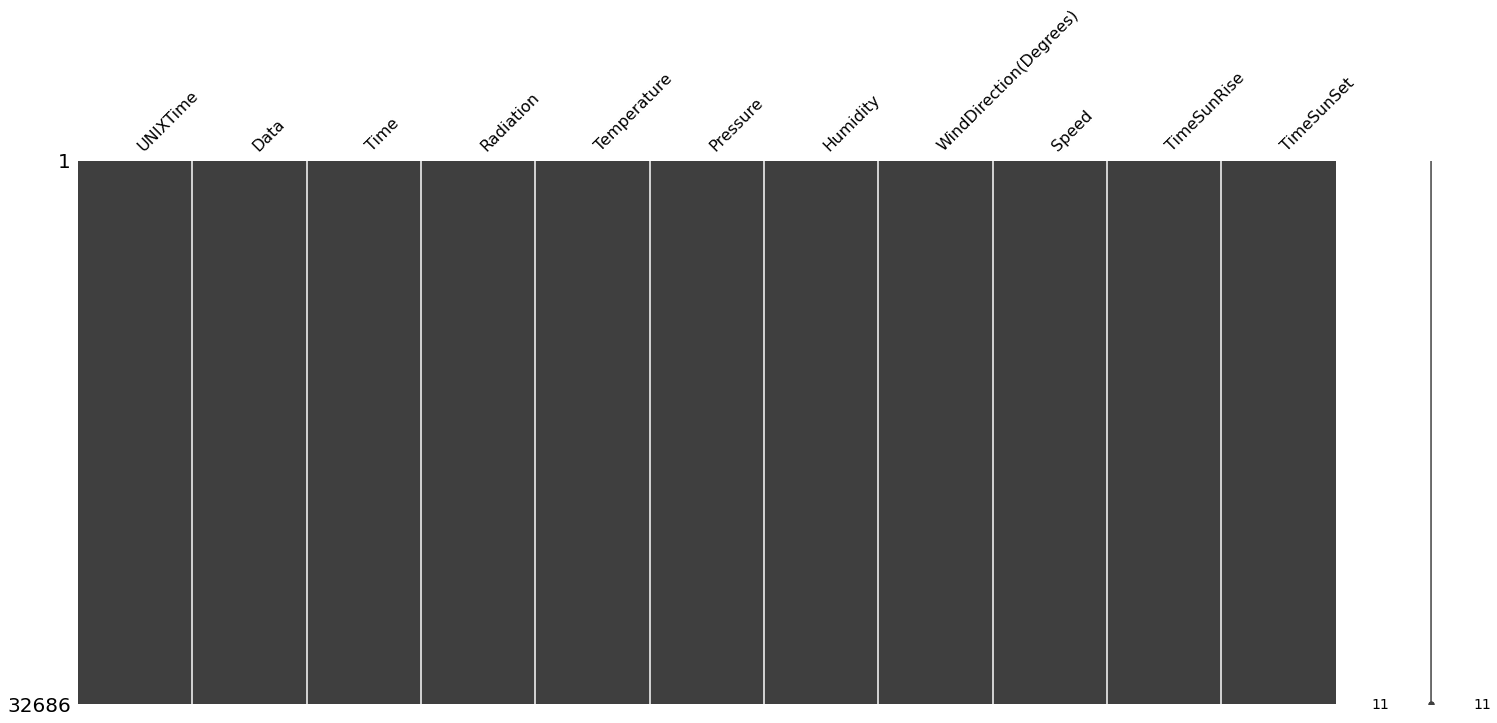

In [4]:
missingno.matrix(df)

As we can see we don't have any missing values in the provided dataset.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


We notice that some of the columns are strings so we will convert them to datetime objects

In [6]:
def preprocess_data(df):

    """
    Description:
        Convert timezone to Hawaii
        Rename some of the columns
        Convert string columns to datetime objects
        add new feature from TimeSunSet and TimeSunRise columns
    
    Args:
        val: input df (DataFrame)
        
    Returns:
        df -> preprocessed DataFrame
    """

    #'Data' - all elements contain the same value.
    #we have UNIXTime so we can drop Time.
    df.drop(['Data','Time'],axis=1,inplace=True)

    # index by UNIX time
    df['UNIXTime'] = pd.to_datetime(df['UNIXTime'], unit='s')
    df.sort_values('UNIXTime', inplace=True) # sort by UNIXTime
    df.set_index('UNIXTime',inplace=True) # index by UNIXTime
    
     # Localize the index (using tz_localize) to UTC (to make the Timestamps timezone-aware) and then convert to Eastern (using tz_convert)
    hawaii= timezone('Pacific/Honolulu')
    df.index = df.index.tz_localize(pytz.utc).tz_convert(hawaii)

    #rename some of the columns
    df.rename(columns={'WindDirection(Degrees)': 'WindDirection', 'Speed': 'WindSpeed'}, inplace=True)

    #convert string columns to datetime objects
    df['day_of_month'] = df.index.day
    df['week_of_year'] = df.index.week
    df['month'] = df.index.month
    df['hour'] = df.index.hour 
    df['Date'] = df.index.date

    #extract sunrise and sunrise hour and minute
    df['SunriseHour'] = df['TimeSunRise'].apply(lambda x: re.search(r'^\d+', x).group(0)).astype(np.int)
    df['SunriseMinute'] = df['TimeSunRise'].apply(lambda x: re.search(r'(?<=:)\d+(?=:)',x).group(0)).astype(np.int)

    df['SunsetHour'] = df['TimeSunSet'].apply(lambda x: re.search(r'^\d+', x).group(0)).astype(np.int)
    df['SunsetMinute'] = df['TimeSunSet'].apply(lambda x: re.search(r'(?<=:)\d+(?=:)',x).group(0)).astype(np.int)

    df['daylight']=df['SunsetHour']-df['SunriseHour']

    df.drop(['TimeSunRise', 'TimeSunSet'],axis=1,inplace = True)
    
    return df

In [7]:
df = preprocess_data(df)
df.head()

<ipython-input-6-d7e8e3f3f30c>:35: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week_of_year'] = df.index.week


Radiation  Temperature  Pressure  Humidity  \
UNIXTime                                                                
2016-09-01 00:00:08-10:00       2.58           51     30.43       103   
2016-09-01 00:05:10-10:00       2.83           51     30.43       103   
2016-09-01 00:20:06-10:00       2.16           51     30.43       103   
2016-09-01 00:25:05-10:00       2.21           51     30.43       103   
2016-09-01 00:30:09-10:00       2.25           51     30.43       103   

                           WindDirection  WindSpeed  day_of_month  \
UNIXTime                                                            
2016-09-01 00:00:08-10:00          77.27      11.25             1   
2016-09-01 00:05:10-10:00         153.44       9.00             1   
2016-09-01 00:20:06-10:00         142.04       7.87             1   
2016-09-01 00:25:05-10:00         144.12      18.00             1   
2016-09-01 00:30:09-10:00          67.42      11.25             1   

                           week_of_year  month  hour        Date  SunriseHour  \
UNIXTime                                                                        
2016-09-01 00:00:08-10:00            35      9     0  2016-09-01            6   
2016-09-01 00:05:10-10:00            35      9     0  2016-09-01            6   
2016-09-01 00:20:06-10:00            35      9     0  2016-09-01            6   
2016-09-01 00:25:05-10:00            35      9     0  2016-09-01            6   
2016-09-01 00:30:09-10:00            35      9     0  2016-09-01            6   

                           SunriseMinute  SunsetHour  SunsetMinute  daylight  
UNIXTime                                                                      
2016-09-01 00:00:08-10:00              7          18            38        12  
2016-09-01 00:05:10-10:00              7          18            38        12  
2016-09-01 00:20:06-10:00              7          18            38        12  
2016-09-01 00:25:05-10:00              7          18            38        12  
2016-09-01 00:30:09-10:00              7          18            38        12

## Exploratory Data Analysis

In this stage we perform initial investigations on the dataset in order to discover patterns, spot anomalies,test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

In [9]:
fig = make_subplots(rows=3, cols=2)
Radiation = go.Histogram(x=df.Radiation, name='Radiation')
Temperature = go.Histogram(x=df.Temperature, name='Temperature')
Pressure = go.Histogram(x=df.Pressure, name='Pressure')
Humidity = go.Histogram(x=df.Humidity,name='Humidity')
#Speed = go.Histogram(x=df.Speed)
WindDirection = go.Histogram(x=df["WindDirection"],name='WindDirection')
fig.append_trace(Radiation, 1, 1)
fig.append_trace(Temperature, 1, 2)
fig.append_trace(Pressure, 2, 1)
fig.append_trace(Humidity, 2, 2)
#fig.append_trace(Speed, 3, 1)
fig.append_trace(WindDirection, 3, 1)
fig.show()

<AxesSubplot:xlabel='Temperature', ylabel='Humidity'>

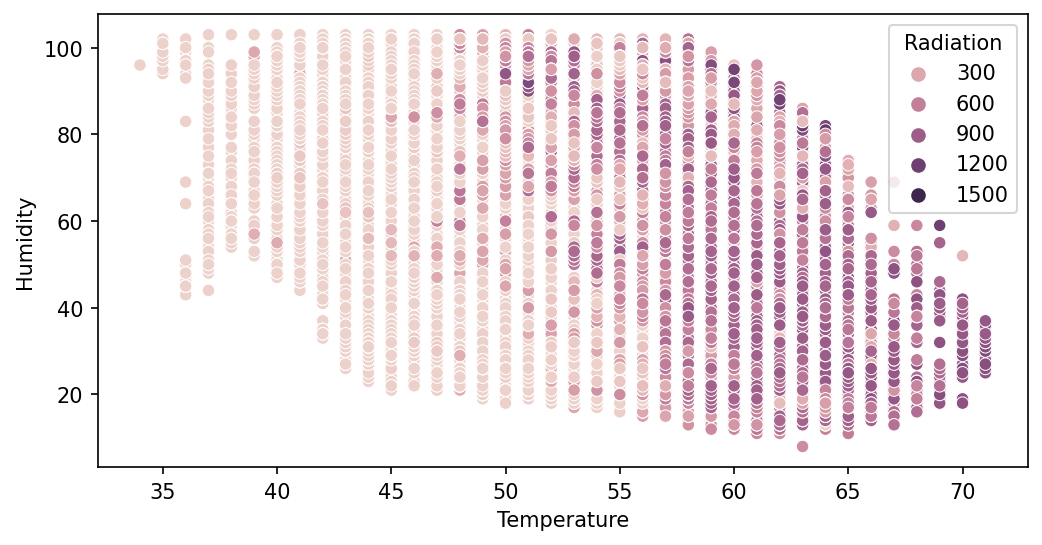

In [10]:
plt.figure(figsize=(8,4),dpi=150)
sns.scatterplot(x=df.Temperature, y=df.Humidity ,hue=df.Radiation)

In [11]:
fig = px.scatter_matrix(df,
    dimensions=["Temperature", "Pressure", "Humidity"],
    color="Radiation")
fig.show()

In [12]:
fig = px.scatter_matrix(df[(df.index.month==9) & (df.index.day==2)],
    dimensions=["Temperature", "Pressure", "Humidity"],
    color="Radiation")
fig.show()

In [13]:
x = df.index[(df.index.month==11)]
y1= df.Radiation[(df.index.month==11)].values
y2= df.Temperature[(df.index.month==11)].values
y3 = df.Pressure[(df.index.month==11)].values
y4 = df.Humidity[(df.index.month==11)].values


fig = make_subplots(rows=3, cols=2)
Radiation = go.Line(x=x, y=y1,name='Radiation')
Temperature = go.Line(x=x, y=y2,name='Temperature')
Pressure = go.Line(x=x, y=y3,name='Pressure')
Humidity = go.Line(x=x, y=y4,name='Humidity')


fig.append_trace(Radiation, 1, 1)
fig.append_trace(Temperature, 2, 1)
fig.append_trace(Pressure, 1, 2)
fig.append_trace(Humidity, 2, 2)


fig.show()

C:\Users\ndani\AppData\Local\Programs\Python\Python39\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




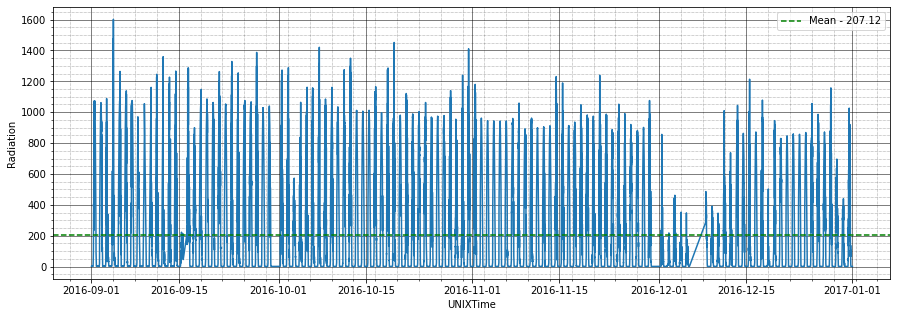

In [14]:
f, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=df, x=df.index, y="Radiation")
mean_avg=df['Radiation'].mean()
ax.axhline(mean_avg, color='green', linestyle='--', label=f"Mean - {mean_avg:.2f}")
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth=0.5, color='black',)
ax.grid(which='minor', linestyle=':', linewidth=0.5, color='black', alpha=0.7)
ax.legend();

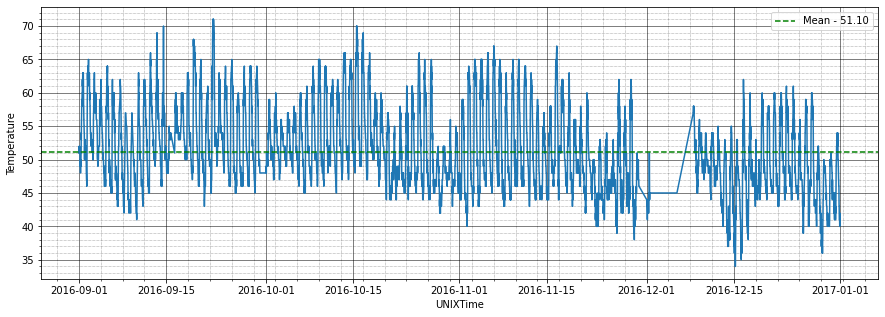

In [15]:
f, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=df, x=df.index, y="Temperature")
mean_avg=df['Temperature'].mean()
ax.axhline(mean_avg, color='green', linestyle='--', label=f"Mean - {mean_avg:.2f}")
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth=0.5, color='black',)
ax.grid(which='minor', linestyle=':', linewidth=0.5, color='black', alpha=0.7)
ax.legend();

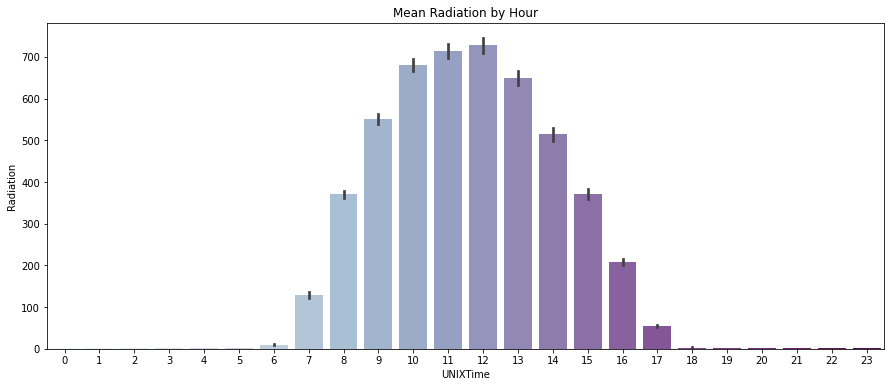

In [16]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x=df.index.hour, y='Radiation', data=df, palette="BuPu")
ax.set_title('Mean Radiation by Hour');

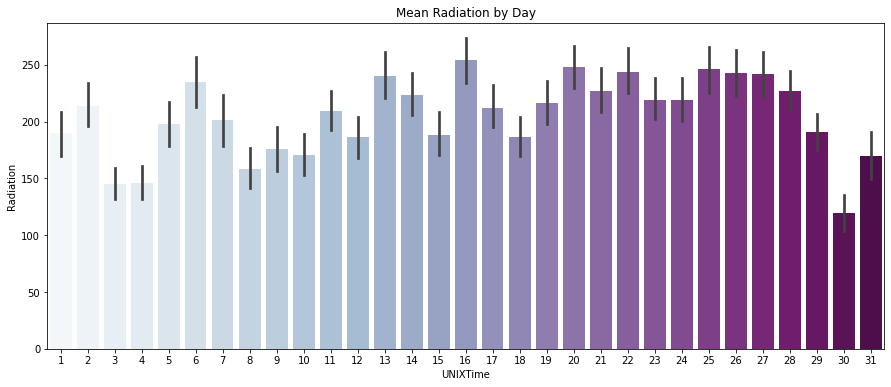

In [17]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x=df.index.day, y='Radiation', data=df, palette="BuPu")
ax.set_title('Mean Radiation by Day');

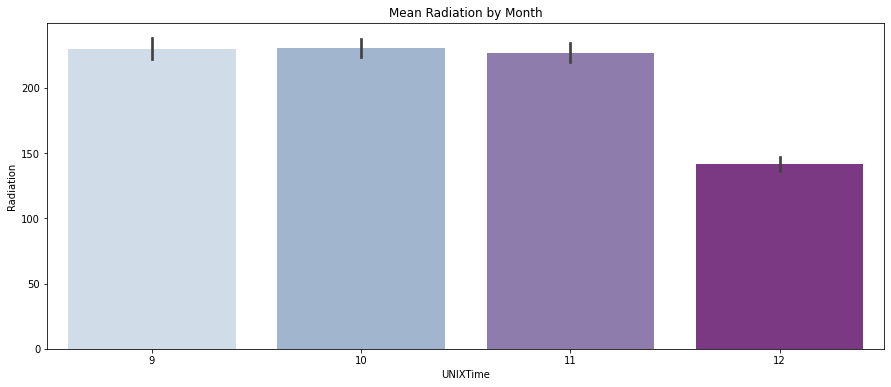

In [18]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x=df.index.month, y='Radiation', data=df, palette="BuPu")
ax.set_title('Mean Radiation by Month');

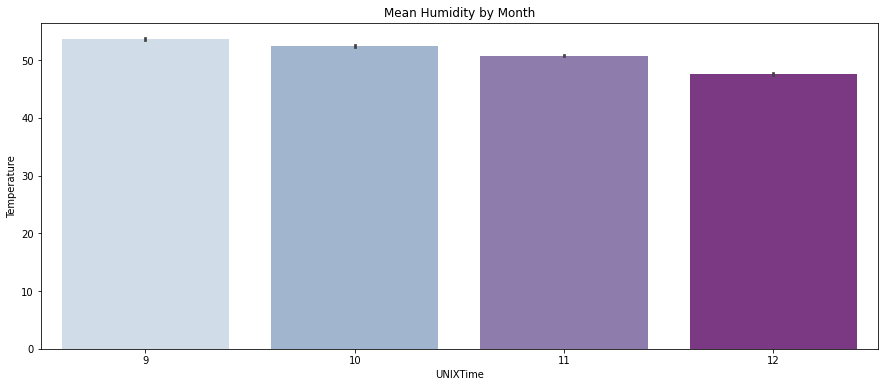

In [19]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x=df.index.month, y='Temperature', data=df, palette="BuPu")
ax.set_title('Mean Humidity by Month');

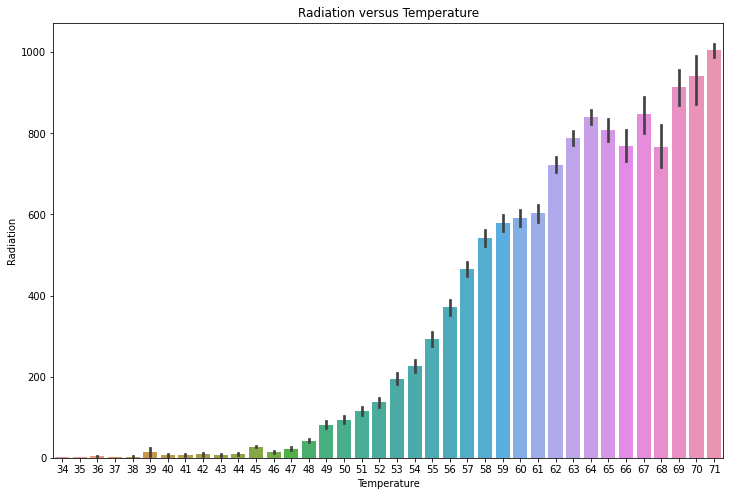

In [20]:

plt.figure(figsize=(12,8))
sns.barplot(x=df.Temperature ,y=df.Radiation)
plt.xlabel('Temperature')
plt.ylabel('Radiation')
plt.title('Radiation versus Temperature')
plt.show()

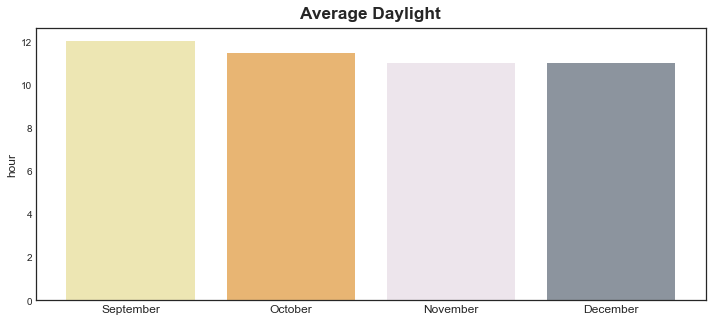

In [21]:
plt.style.use('seaborn-white')
avg_daylight = df.groupby('month')['daylight'].mean()
c = ['#ede6b3', '#e8b573', '#ede5ec', '#8c949e']
plt.figure(figsize=(12,5))
plt.title('Average Daylight',fontsize=12,size = 'xx-large',pad=10,weight = 'bold')
plt.bar(avg_daylight.index, avg_daylight,color=c)
plt.xticks(avg_daylight.index,['September','October','November','December'],fontsize=12)
plt.ylabel('hour',fontsize=12)
plt.show()

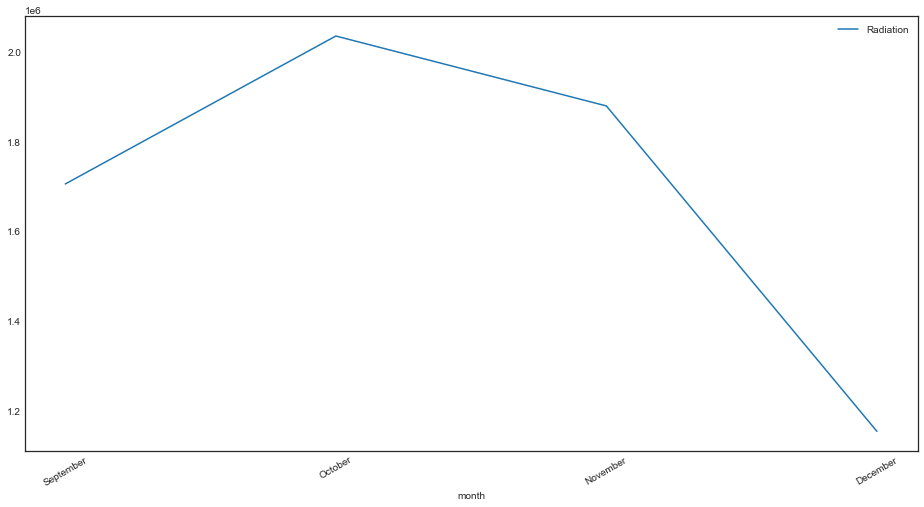

In [22]:
plt.rcParams['figure.figsize'] = (16,8)
months = np.arange(9,13)
rad_vs_month=df.loc[:, ['Radiation', 'month']].groupby('month').sum()
rad_vs_month.plot()
plt.xticks(months,['September', 'October', 'November', 'December'], rotation=30)
plt.show()

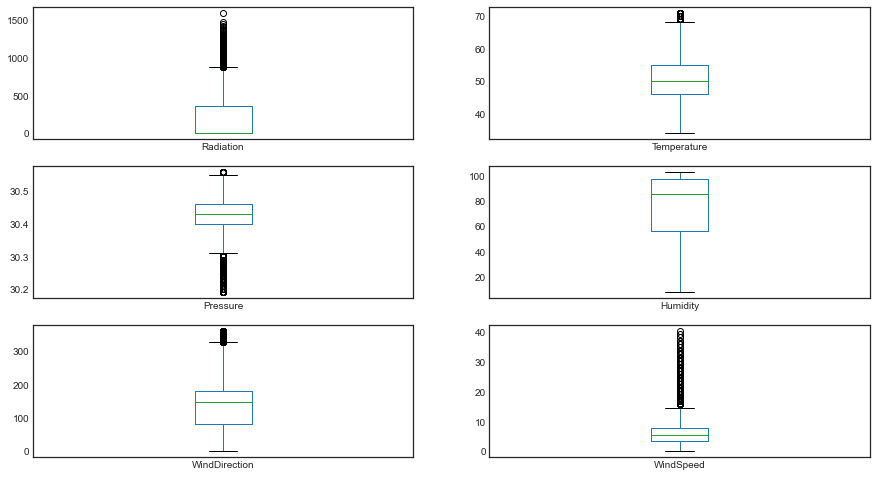

In [83]:
df[['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection',
       'WindSpeed']].plot(kind="box",subplots=True,layout=(7,2),figsize=(15,20))
plt.show()

Percentage of datapoints considered outlier for Radiation

In [90]:
np.round((df[df['Radiation']>900]['Radiation'].count())/(len(df['Radiation']))*100,2)

5.31

Percentage of datapoints considered outlier for Windspeed


In [91]:
np.round((df[df['WindSpeed']>15]['WindSpeed'].count())/(len(df['WindSpeed']))*100,2)

1.47

### Outlier removal

In [95]:
from sklearn.ensemble import IsolationForest

def outlier_removal(df, ind=-1):

    log_header = ['Radiation','WindSpeed','Pressure']
    print('Before anomaly treatment\n',df[['Radiation','WindSpeed','Pressure']].describe())
    # major parameter percentage of outlier present with parameter contamination, nu : 2 %
    outliers_frac = 0.02
    # define outlier/anomaly detection methods to be compared
    anomaly_algorithm = [('Isolation Forest', IsolationForest(n_estimators=100, max_samples='auto',
                         contamination=outliers_frac, random_state=42))]
        
    fig = plt.figure(figsize=(15, 10))
    fig.subplots_adjust(hspace=0.4, wspace=0.6)
    fig.suptitle('Anomaly detection using Isolation Forest')


# detect anomaly for each features
    for i, item in enumerate(log_header):

        temp = 311+i  # this is to index the position of the subplot
        plt.subplot(temp)
        # Automatic anomaly flagging on whole data sample with inliers labeled as 1 and outliers labeled as -1
        anomaly = anomaly_algorithm[0][1].fit_predict(df[[item]])
        plt.scatter(df.Date, df[item], label='original', marker='o',s=4)
        plt.scatter(df.Date[anomaly==-1], df[item][anomaly==-1], 
                        marker='^', label='outliers',s=4)
        plt.ylabel(item)
        plt.xlabel('Date')
        plt.legend(loc='upper right')
 
        print('\nNumber of anomalies detected for', item, '=', -sum(anomaly[anomaly==-1]),'out of', anomaly.shape[0])
        counter = np.zeros(df.shape[0])
        counter += anomaly

        df = df[anomaly==1]
        print('Number of data points after anomalies removal =',df.shape[0])
    
    print('After anomaly treatment\n',df[['Radiation','WindSpeed','Pressure']].describe())
    return df

In [96]:
data = outlier_removal(df, ind=-1)

Before anomaly treatment
           Radiation     WindSpeed      Pressure
count  32686.000000  32686.000000  32686.000000
mean     207.124697      6.243869     30.422879
std      315.916387      3.490474      0.054673
min        1.110000      0.000000     30.190000
25%        1.230000      3.370000     30.400000
50%        2.660000      5.620000     30.430000
75%      354.235000      7.870000     30.460000
max     1601.260000     40.500000     30.560000

Number of anomalies detected for Radiation = 654 out of 32686
Number of data points after anomalies removal = 32032

Number of anomalies detected for WindSpeed = 467 out of 32032
Number of data points after anomalies removal = 31565

Number of anomalies detected for Pressure = 582 out of 31565
Number of data points after anomalies removal = 30983
After anomaly treatment
           Radiation     WindSpeed      Pressure
count  30983.000000  30983.000000  30983.000000
mean     188.838996      6.021297     30.425183
std      293.445723    

In [97]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
df[['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection',
       'WindSpeed']].boxplot()
plt.title('Before Outlier Removal', size=15)

plt.subplot(1,2,2)
data[['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection',
       'WindSpeed']].boxplot()
plt.title('After Outlier Removal with Isolation Forest', size=15)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Features Correlating with Radiation')

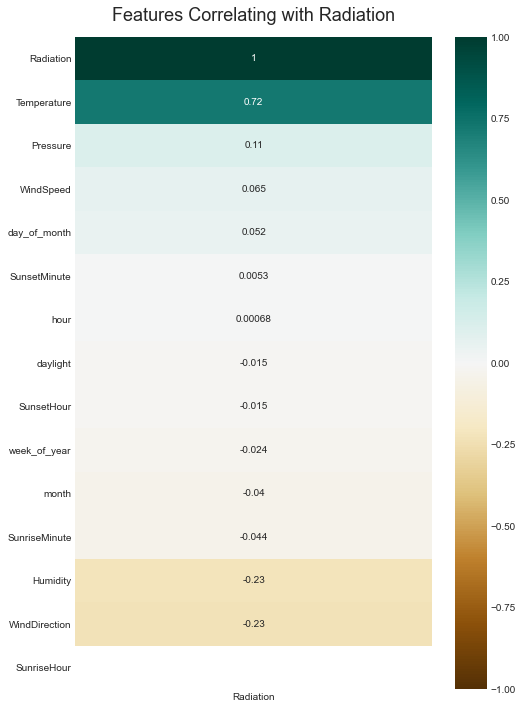

In [100]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(data.corr()[['Radiation']].sort_values(by='Radiation', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Radiation', fontdict={'fontsize':18}, pad=16)

From this exploration of the data, we see the following patterns in this dataset:

- Higher temperatures correlate to more radiation throughput. This is confirmed by a Pearson R-value of 0.72 and the observed behavior of radiation "following" temperature on the daily and weekly time scales.


- Humidity has a lesser (but potentially significant) impact on radiation throughput. With a Pearson R-value of magnitude above 0.20, humidity cannot be ignored as a potential driver of the system.


- Pressure doesn't correlate much to radiation, but does correlate to temperature and humidity. Weather, basically. Since temperature, pressure, and humidity are all characteristics of the atmosphere it is not surprising that they are correlated.


-  Wind direction has a moderate correlation to temperature (-0.26), pressure (-0.23) and radiation (-0.23) but through engineering judgement we know that this is only correlation and not causation.
Seasonal changes are significant. Even though Hawai'i does not see seasons as drastic as the northern continental United States, seasonal changes in temperature and humidity are still severe enough to be taken into account, as shown by the weekly measurement comparisons.


- Month-to-month variation is too broad to capture seasonal changes within a single year. Since day-to-day weather is dominated by temperature, pressure, and humidity (rather than seasonal changes), week of the year is the best indicator of seasonal trends.

## ML prediction